In [1]:
import pubchempy as pcp #getting compounds from PubChem
from rdkit import Chem #importing RDKit to draw molecules
from rdkit.Chem import Draw
import pandas as pd
from IPython.display import display, Image

In [604]:

# Definições de padrões SMARTS para diferentes grupos funcionais
functional_groups = {
    'Álcool primário': '[$([C;!$(C=O);$([C;H2][OH])])]',  # Grupo hidroxila ligado a um carbono sp3
    'Álcool secundário': '[$([C;!$(C=O);$([C;H1][OH])])]',  # Grupo hidroxila ligado a um carbono sp2
    'Álcool terciário':'[$([C;!$(C=O);$([C;H0][OH])])]', # Grupo hidroxila ligado a um carbono sp
    'Aldeído': '[$([CH]=O)]',  # Carbono duplamente ligado a oxigênio e ligado a um hidrogênio
    'Cetona': '[#6][CX3](=O)[#6]',  # Carbono duplamente ligado a oxigênio e ligado a dois carbonos
    'Ácido carboxílico': '[$([CX3](=O)[OX2H1])]',  # Carbono duplamente ligado a oxigênio e ligado a um grupo hidroxila
    'Éster': '[$([CX3](=O)[OX2][CX4])]',  # Carbono duplamente ligado a oxigênio e ligado a um oxigênio ligado a outro carbono
    'Amina primária': '[$([N;H2][C])]',  # Nitrogênio ligado a um carbono sp3 e dois hidrogênios
    'Amina secundária': '[$([N;H1][C][C])]',  # Nitrogênio ligado a um carbono sp3 e um hidrogênio
    'Amina terciária': '[$([N;H0][C][C][C])]',  # Nitrogênio ligado a três carbonos sp3
    'Amida primária': '[CX3](=O)[NX3H2]',
    'Amida secundária': '[CX3](=O)[NX3H1][CX4]',
    'Amida terciária': '[CX3](=O)[NX3]([CX4])[CX4]',
    'Éter': '[C;!$(C=O)]-O-[C;!$(C=O)]',  # Oxigênio ligado a dois carbonos sp3
    'Haleto de alquila': '[#6][F,Cl,Br,I]',  # Halogênio ligado a um carbono sp3
    'Tiol': '[#6][SH]',  # Grupo tiol
    'Alceno':'[#6]=[#6]',
    'Alcino': '[#6]#[#6]'  # Tripla ligação carbono-carbono
}


In [595]:

def identify_functional_groups(smiles):
    mol2 = Chem.MolFromSmiles(smiles)
    if mol2 is None:
        raise ValueError("Invalid SMILES string")
    
    identified_groups = {}
    
    for group_name, smarts in functional_groups.items():
        patt = Chem.MolFromSmarts(smarts)
        if mol2.HasSubstructMatch(patt):
            identified_groups[group_name] = mol2.GetSubstructMatches(patt)
    
    return identified_groups


In [596]:
def create_functional_groups_dataframe(identified_groups):
    group_counts = {group: len(matches) for group, matches in identified_groups.items()}
    df = pd.DataFrame(list(group_counts.items()), columns=['Função Orgânica', 'Quantidade'])
    return df

In [597]:
def draw_molecule_with_functional_groups(smiles):
    mol = Chem.MolFromSmiles(smiles)
    drawer = Draw.rdMolDraw2D.MolDraw2DCairo(500, 500)
    drawer.DrawMolecule(mol)
    drawer.FinishDrawing()
    
    mol2 = Chem.MolFromSmiles(smiles)
    if mol2 is None:
        raise ValueError("Invalid SMILES string")

    
    identified_groups = identify_functional_groups(smiles)
    drawer2 = Draw.rdMolDraw2D.MolDraw2DCairo(500, 500)
    opts = drawer2.drawOptions()
    
    highlight_atoms = []
    highlight_bonds = []
    highlight_colors = {}

    color_palette = [
        (1.0, 1.0, 0.0),  # Yellow
        (0.3, 1.0, 0.0),  # Green
        (0.2, 0.6, 1.0),  # Light Blue
        (1.0, 0.5, 0.0),  # Orange
        (1.0, 0.5, 1.0),  # Magenta
        (0.0, 1.0, 1.0),  # Cyan
    ]
    
    color_idx = 0
    
    for group_name, matches in identified_groups.items():
        color = color_palette[color_idx % len(color_palette)]
        color_idx += 1
        for match in matches:
            highlight_atoms.extend(list(match))
            highlight_colors.update({i: color for i in match})
            # Add bonds to the highlight list
            for i in range(len(match) - 1):
                bond = mol2.GetBondBetweenAtoms(match[i], match[i+1])
                if bond is not None:
                    highlight_bonds.append(bond.GetIdx())
            # Ensure to add the last bond in the functional group
            if len(match) > 2:
                bond = mol2.GetBondBetweenAtoms(match[-1], match[0])
                if bond is not None:
                    highlight_bonds.append(bond.GetIdx())
    
    drawer2.DrawMolecule(
        mol2,
        highlightAtoms=highlight_atoms,
        highlightBonds=highlight_bonds,
        
        highlightAtomColors=highlight_colors,
    )
    drawer2.FinishDrawing()
    return drawer.GetDrawingText(), drawer2.GetDrawingText()


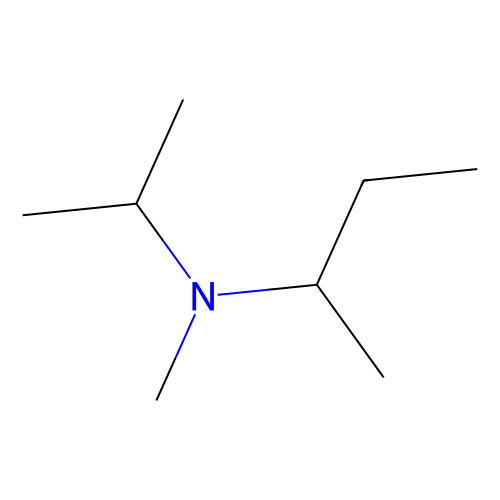

,Função Orgânica,Quantidade
0,Amina terciária,1


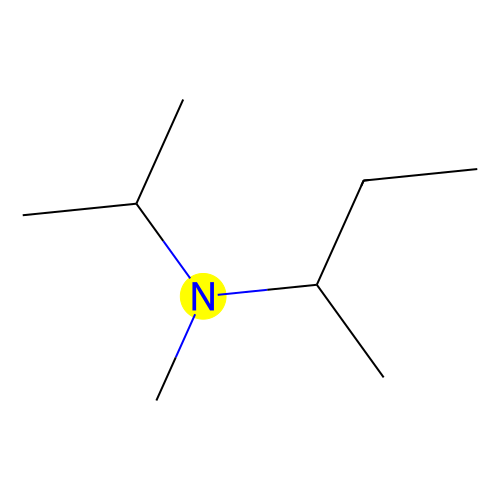

In [613]:
# Exemplo de uso
smiles = "C(C)(C)N(C)C(C)C(C)" 
identified_groups = identify_functional_groups(smiles)
img_data,img_data_groups = draw_molecule_with_functional_groups(smiles)
display(Image(img_data))
#cid = pcp.get_compounds(smiles, 'smiles')
#c = pcp.Compound.from_cid(cid[0].cid)
#print('IUPAC Name: ' + c.iupac_name)
#print('Molecular formula: ' + c.molecular_formula)
#print('Molecular weight: ' + c.molecular_weight + ' g/mol\n')

# Criar DataFrame
df = create_functional_groups_dataframe(identified_groups)
display(df)

display(Image(img_data_groups))
# Salva a imagem para um arquivo
with open('molecule.png', 'wb') as f:
    f.write(img_data_groups)